# Merging & EDA

| Date | User | Change Type | Remarks |  
| ---- | ---- | ----------- | ------- |
| 22/09/2025   | Martin | Created   | Notebook created for merging and EDA | 
| 23/09/2025   | Martin | New   | Re-explored claims data. Added findings | 
| 26/09/2025   | Martin | New   | Additional claim processing. Breakdown of DRG codes in processed claims | 

# Content

* [Loading Data](#loading-data)
* [Further Claim Processing](#further-claim-processing)
* [Merging Data](#merging-data)
* [Exploring a Patient](#exploring-a-patient)
* [EDA](#eda)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from collections import OrderedDict
from io import StringIO

# Loading Data

In [2]:
%load_ext watermark

In [3]:
path = "../data/clean"
# claim = pd.read_pickle(f"{path}/claim_sample.pkl")
claim_old = pd.read_pickle(f"{path}/claim_old.pkl")
# claim_resp = pd.read_pickle(f"{path}/claim_response.pkl")
patient = pd.read_pickle(f"{path}/patient.pkl")
eob = pd.read_pickle(f"{path}/explanation_of_benefit.pkl")
# coverage = pd.read_pickle(f"{path}/coverage.pkl")

In [4]:
# Select relevant columns for initial exploration
patient = patient[['address_0_state', 'birthDate', 'deceasedBoolean', 'extension_1_valueCoding_display', 'extension_3_valueDate', 'gender', 'id', 'identifier_1_value', 'deceasedBoolean', 'deceasedDateTime', 'address_0_postalCode']]
patient = patient.rename({
  'extension_1_valueCoding_display': 'race',
  'extension_3_valueDate': 'referenceYear',
  'identifier_1_value': 'patient_medicare_number',
  'address_0_postal_code': 'postalCode'
}, axis=1)


# l = claim_resp[['id', 'contained_birthDate', 'contained_gender', 'identifier_value', 'contained_identifer_patient_medicare_number']]
# claim_ids = claim[['id', 'patient_medicare_number', 'identifier_0_value']]

In [30]:
claim.head()

,billablePeriod_end,billablePeriod_start,contained_0_birthDate,contained_0_extension_0_url,contained_0_extension_0_valueCode,contained_0_gender,contained_0_id,contained_0_identifier_0_system,contained_0_identifier_0_type_coding_0_code,contained_0_identifier_0_type_coding_0_display,...,item_153_detail_0_quantity_system,item_153_detail_0_quantity_unit,item_153_detail_0_quantity_value,item_153_detail_0_sequence,patient_medicare_number,patient_number,patient_first_name,patient_last_name,unique_claim_ID,hcpcs_code
169882,2014-02-28,2014-02-28,1941-01-18,http://hl7.org/fhir/us/core/StructureDefinitio...,248152002,female,patient,http://hl7.org/fhir/sid/us-mbi,MC,Patient's Medicare Number,...,NaN,NaN,NaN,NaN,1S00E00AF65,#patient,Ayanna800,Ankunding277,dcn913199412b509a02572,NaN
6898,2021-04-27,2021-04-27,1945-05-22,http://hl7.org/fhir/us/core/StructureDefinitio...,248152002,female,patient,http://hl7.org/fhir/sid/us-mbi,MC,Patient's Medicare Number,...,NaN,NaN,NaN,NaN,1S00E00AH76,#patient,Noelle559,Effertz744,dcn2ac4a08763e8b3c014d,NaN
90865,2012-07-07,2012-07-07,1942-11-09,http://hl7.org/fhir/us/core/StructureDefinitio...,248153007,male,patient,http://hl7.org/fhir/sid/us-mbi,MC,Patient's Medicare Number,...,NaN,NaN,NaN,NaN,1S00E00AD77,#patient,Jospeh459,Mann644,dcnd7eaca00aa08dffa3b4,NaN
50171,2009-08-03,2009-08-03,1951-05-21,http://hl7.org/fhir/us/core/StructureDefinitio...,248152002,female,patient,http://hl7.org/fhir/sid/us-mbi,MC,Patient's Medicare Number,...,NaN,NaN,NaN,NaN,1S00E00AE47,#patient,Shakira391,Pagac496,dcnacf05ac1b4df8475210,NaN
105232,2021-03-15,2021-03-15,1947-04-28,http://hl7.org/fhir/us/core/StructureDefinitio...,248153007,male,patient,http://hl7.org/fhir/sid/us-mbi,MC,Patient's Medicare Number,...,NaN,NaN,NaN,NaN,1S00E00MC18,#patient,Lauren941,Kling921,100204954,99241


# Further Claim Processing

## Re-exploring some details from claim

<u>Findings</u>

- `diagnosis` can be split into individual code columns since all of them are ICD-10-CM codes and the max length is 23 for the list = max 23 new columns
  - Missing on few rows
  - The sequences are also all in order, so we can represent them as a sequence data type
  - https://www.icd10data.com/ICD10CM/Codes/S00-T88
- Some of the entries in claim are (I think) exactly the same, they only differ by their billablePeriod. See entry 1 and 2 in raw `Claim.ndjson`

In [ ]:
path = "../data/clean"
claim_old = pd.read_pickle(f'{path}/claim_old.pkl')

In [ ]:
claim_old.shape

In [ ]:
lengths = []
for i in claim_old['diagnosis']:
  if not isinstance(i, float):
    lengths.append(len(i))

print(pd.Series(lengths).unique())
print(len(lengths))

In [ ]:
codes = []
for entry in claim_old['diagnosis']:
  t = []
  if not isinstance(entry, float):
    for item in entry:
      t.append(item['diagnosisCodeableConcept']['coding'][0]['code'])
  codes.append(t)

In [ ]:
# We can explore this list into columns
pd.DataFrame({
  'codes': codes
})

## Additional processing on claims

In [2]:
claim = pd.read_json("../data/raw/Claim.ndjson", lines=True)

In [33]:
claim.head()

,billablePeriod,contained,created,diagnosis,extension,facility,id,identifier,insurance,item,...,patient,priority,provider,resourceType,status,supportingInfo,total,type,use,procedure
0,"{'end': '2012-09-16', 'start': '2012-09-16'}","[{'birthDate': '1944-05-25', 'extension': [{'u...",2025-08-31T21:23:49+00:00,[{'diagnosisCodeableConcept': {'coding': [{'co...,[{'url': 'https://bluebutton.cms.gov/resources...,{'extension': [{'url': 'https://bluebutton.cms...,f-LTEwMDAwMDAzNTUxNzU5,[{'system': 'https://bluebutton.cms.gov/resour...,[{'coverage': {'identifier': {'system': 'https...,[{'extension': [{'url': 'https://bluebutton.cm...,...,{'reference': '#patient'},"{'coding': [{'code': 'normal', 'display': 'Nor...",{'reference': '#provider-org'},Claim,active,[{'category': {'coding': [{'code': 'typeofbill...,"{'currency': 'USD', 'value': 119.62}","{'coding': [{'code': 'institutional', 'display...",claim,NaN
1,"{'end': '2013-06-11', 'start': '2013-06-11'}","[{'birthDate': '1944-05-25', 'extension': [{'u...",2025-08-31T21:23:49+00:00,[{'diagnosisCodeableConcept': {'coding': [{'co...,[{'url': 'https://bluebutton.cms.gov/resources...,{'extension': [{'url': 'https://bluebutton.cms...,f-LTEwMDAwMDAzNTUxNzY0,[{'system': 'https://bluebutton.cms.gov/resour...,[{'coverage': {'identifier': {'system': 'https...,[{'extension': [{'url': 'https://bluebutton.cm...,...,{'reference': '#patient'},"{'coding': [{'code': 'normal', 'display': 'Nor...",{'reference': '#provider-org'},Claim,active,[{'category': {'coding': [{'code': 'typeofbill...,"{'currency': 'USD', 'value': 119.62}","{'coding': [{'code': 'institutional', 'display...",claim,NaN
2,"{'end': '2014-04-02', 'start': '2014-04-01'}","[{'birthDate': '1944-05-25', 'extension': [{'u...",2025-08-31T21:23:49+00:00,[{'diagnosisCodeableConcept': {'coding': [{'co...,[{'url': 'https://bluebutton.cms.gov/resources...,{'extension': [{'url': 'https://bluebutton.cms...,f-LTEwMDAwMDAzNTUxNzY4,[{'system': 'https://bluebutton.cms.gov/resour...,[{'coverage': {'identifier': {'system': 'https...,[{'extension': [{'url': 'https://bluebutton.cm...,...,{'reference': '#patient'},"{'coding': [{'code': 'normal', 'display': 'Nor...",{'reference': '#provider-org'},Claim,active,[{'category': {'coding': [{'code': 'typeofbill...,"{'currency': 'USD', 'value': 119.62}","{'coding': [{'code': 'institutional', 'display...",claim,NaN
3,"{'end': '2014-11-18', 'start': '2014-11-17'}","[{'birthDate': '1944-05-25', 'extension': [{'u...",2025-08-31T21:23:49+00:00,[{'diagnosisCodeableConcept': {'coding': [{'co...,[{'url': 'https://bluebutton.cms.gov/resources...,{'extension': [{'url': 'https://bluebutton.cms...,f-LTEwMDAwMDAzNTUxNzc2,[{'system': 'https://bluebutton.cms.gov/resour...,[{'coverage': {'identifier': {'system': 'https...,[{'extension': [{'url': 'https://bluebutton.cm...,...,{'reference': '#patient'},"{'coding': [{'code': 'normal', 'display': 'Nor...",{'reference': '#provider-org'},Claim,active,[{'category': {'coding': [{'code': 'typeofbill...,"{'currency': 'USD', 'value': 119.62}","{'coding': [{'code': 'institutional', 'display...",claim,NaN
4,"{'end': '2016-04-04', 'start': '2016-04-04'}","[{'birthDate': '1944-05-25', 'extension': [{'u...",2025-08-31T21:23:49+00:00,[{'diagnosisCodeableConcept': {'coding': [{'co...,[{'url': 'https://bluebutton.cms.gov/resources...,{'extension': [{'url': 'https://bluebutton.cms...,f-LTEwMDAwMDAzNTUxNzc4,[{'system': 'https://bluebutton.cms.gov/resour...,[{'coverage': {'identifier': {'system': 'https...,[{'extension': [{'url': 'https://bluebutton.cm...,...,{'reference': '#patient'},"{'coding': [{'code': 'normal', 'display': 'Nor...",{'reference': '#provider-org'},Claim,active,[{'category': {'coding': [{'code': 'typeofbill...,"{'currency': 'USD', 'value': 119.62}","{'coding': [{'code': 'institutional', 'display...",claim,NaN


In [94]:
def flatten_json(nested_json, prefix=''):
    """
    Recursively flattens a nested JSON object or dictionary into a single level.

    Notes:
        - Nested dictionaries and lists are flattened such that keys from deeper levels
          in the hierarchy are concatenated with underscores
        - Lists of dictionaries are handled by appending index numbers to the keys.
        - Non-dict lists are serialized using JSON encoding
        - Returns OrderedDict, a flattened version of the input json, where keys represent
          the nested structure and values are the corresponding data
    """
    out = OrderedDict()
    for key, value in nested_json.items():
        if isinstance(value, dict):
            # Recursively flatten nested dictionaries
            out.update(flatten_json(value, prefix + key + '_'))
        elif isinstance(value, list):
            if len(value) > 0:
                if isinstance(value[0], dict):
                    # Handle list of dictionaries by flattening each item
                    for i, item in enumerate(value):
                        out.update(flatten_json(item, prefix + key + '_' + str(i) + '_'))
                else:
                    # Non-dict lists are serialized into a JSON string
                    out[prefix + key] = json.dumps(value)
            else:
                # Empty lists are serialized as JSON strings
                out[prefix + key] = json.dumps(value)
        else:
            # Base case: key-value pair where value is not a list or dict
            out[prefix + key] = value
    return out

def process_dataframe(df):
    """
    Processes a pandas DataFrame by flattening any JSON-like data (dictionaries or lists)
    present in its columns and converting it into a new DataFrame.

    Notes:
        - The function iterates through each row and flattens any JSON-like data (dictionaries or lists)
        - Non-nested data is left unchanged
        - The resulting DataFrame will contain a combination of original columns and
          additional columns derived from the flattened structure
        - Returns a new pandas DataFrame with the flattened data
    """
    flattened_data = []
    for _, row in df.iterrows():
        flattened_row = {}
        for column, value in row.items():
            if isinstance(value, (dict, list)):
                # Flatten any dictionary or list
                flattened = flatten_json({column: value})
                flattened_row.update(flattened)
            else:
                # Keep non-nested columns unchanged
                flattened_row[column] = value
        flattened_data.append(flattened_row)
    return pd.DataFrame(flattened_data)

In [ ]:
# How many entries have too many items
l = []
for i in claim['item']:
  if not isinstance(i, float):
    l.append(len(i))
m = [i for i, j in enumerate(l) if j <= 50]
plt.hist(l)

In [128]:
temp = claim.copy()

In [ ]:
# ========== Claims ==========
# NOTE: Change max number of HCPC items to include
LIMIT = 50

# 1. item - HCPCS codes
# hcpc_ind = []
hcpcs = []
lengths = []
# rev_cd = []
# non_bill_rev_cd = []

for entry in temp['item']:
  if not isinstance(entry, float):
    items = []
    for item in entry:
      try:
        # hcpc_ind.append(item['extension'][0]['valueCodeableConcept']['coding'][0]['code'])
        items.append(item['productOrService']['coding'][0]['code'])
        # rev_cd.append(item['revenue']['coding'][0]['code'] )
        # non_bill_rev_cd.append(item['revenue']['extension'][0]['valueCodeableConcept']['coding'][0]['code'])
      except:
        print(entry)
        break
    hcpcs.append(items)
    lengths.append(len(items))
  else:
    # hcpc_ind.append(np.nan)
    hcpcs.append([])
    # rev_cd.append(np.nan)
    # non_bill_rev_cd.append(np.nan)
    lengths.append(0)

# Filter for entries with "item" with <X length
hcpcs = pd.DataFrame({
  'all_hcpcs': hcpcs,
  'lengths': lengths
})
idx = hcpcs[hcpcs['lengths'] <= LIMIT].index
sub_hcpcs = hcpcs.iloc[idx]
hcpcs_act = pd.DataFrame(sub_hcpcs['all_hcpcs'].tolist())
hcpcs_act.columns = [f"hcpcs_{i}" for i in range(len(hcpcs_act.columns))]
hcpcs_act['all_hcpcs'] = sub_hcpcs['all_hcpcs']
hcpcs_act = hcpcs_act.reset_index(drop=True)

# Also have to filter the original claims data
temp = temp.iloc[idx].reset_index(drop=True)


# 2. billablePeriod
billablePeriod = process_dataframe(temp[['billablePeriod']])

# 3. contained
contained = process_dataframe(temp[['contained']])
remap = {
  'contained_0_birthDate': 'birth_date',
  'contained_0_gender': 'gender',
  'contained_0_identifier_0_value': 'patient_medicare_number',
  'contained_0_name_0_family': 'family_name',
  'contained_0_name_0_given': 'given_name', # Is a list, take first
  'contained_1_identifier_0_value': 'provider_number', # Those that are len 10 should be below
  'contained_1_identifier_1_value': 'national_provider_identifier'
}
contained = contained.rename(remap, axis=1)
contained = contained[remap.values()]
idx = contained[(contained['provider_number'].str.len() == 10) & (contained['national_provider_identifier'].isna())].index
contained.loc[idx, 'national_provider_identifier'] = contained.loc[idx, 'provider_number']
contained.loc[idx, 'provider_number'] = np.nan

# 4. diagnosis = ICD codes
codes = []
for entry in temp['diagnosis']:
  t = []
  if not isinstance(entry, float):
    for item in entry:
      t.append(item['diagnosisCodeableConcept']['coding'][0]['code'])
  codes.append(t)
codes = pd.DataFrame({
  'all_diagnosis': codes
})
diagnosis = pd.DataFrame(codes['all_diagnosis'].tolist())
diagnosis.columns = [f"diagnosis_{i}" for i in range(len(diagnosis.columns))]
diagnosis['all_diagnosis'] = codes['all_diagnosis']

# 5. supportingInfo = DRG codes
supportingInfo = process_dataframe(temp[['supportingInfo']])
remap = {
  'supportingInfo_0_code_coding_0_code': 'type_of_bill',
  'supportingInfo_1_code_coding_0_code': 'drg'
}
supportingInfo = supportingInfo.rename(remap, axis=1)
supportingInfo = supportingInfo[remap.values()]

# 6. total
total = pd.DataFrame({
  'total': temp['total'].apply(lambda x: x['value'])
})

# 7. type
t = process_dataframe(temp[['type']])
t = t[['type_coding_0_code']]
t = t.rename({'type_coding_0_code': 'claim_type'}, axis=1)

# 8. other columns
other_cols = temp[['resourceType', 'status']]

# Combine them all
processed_claim = pd.concat([
  billablePeriod,
  contained,
  diagnosis,
  hcpcs_act,
  supportingInfo,
  total,
  t,
  other_cols
], axis=1)
processed_claim = processed_claim.replace({None: np.nan})

In [152]:
print(f"Original size of claim: {claim.shape}")
print(f"New size of claim: {processed_claim.shape}")
print()
print(f"Number of entries removed: {claim.shape[0] - processed_claim.shape[0]}")

Original size of claim: (178761, 21)
New size of claim: (177894, 90)

Number of entries removed: 867


In [ ]:
processed_claim.to_pickle('../data/clean/claim_clean.pkl')

# Merging Data

- Coverage (subscriberId) -> (Many-to-One) -> Patient (patient_medicare_number)
  - Not all have a value, but if there is, 4 values per patient (Part A-D)
- EOB (patient) -> (Many-to-One) -> Patient (id)
  - Need to convert EOB col to int
  - Only ~50 patients with information
- Claim (patient_medicare_number) -> (Many-to-One) -> Patient (identifier_1_value)
- Claim Response (id) -> (One-to-One) -> Claim (id)

<u>Findings</u>

- Claim Response has One-to-One relationship with Claim, but doesn't really provide any additional info
- Looked through the claims data again, besides the typical indexing columns and patient info, seems like only diagnosis, priority, claim-type total seem to be the most "relevant" columns (but I'm not too sure based on my limited knowledge of the context)

In [48]:
def find_common_patients(claim, eob, patient):
  """Finds the common patient ids that contain data in all 3 datasets

  Args:
      claim (pd.DataFrame): claim dataset
      eob (pd.DataFrame): eob dataset
      patient (pd.DataFrame): patient dataset

  Returns:
      set: List of Patient IDs
  """
  # Patients that have claim
  l1 = set(claim['patient_medicare_number'].unique()).intersection(patient['patient_medicare_number'])

  # Patients that have an eob & claim info
  l2 = set(patient[patient['patient_medicare_number'].isin(l1)]['id']).intersection(set(eob['patient'].astype(int)))

  # Get the medicare numbers and patient ids
  mcare = set(patient[patient['id'].isin(l2)]['patient_medicare_number'])
  print(len(l1))

  print("Patient Medicare Numbers:")
  print(mcare)
  print()
  print("Patient IDs")
  print(l2)

In [51]:
# These are patients that have data across all the data sets
find_common_patients(claim, eob, patient)

132
Patient Medicare Numbers:
{'1S00E00AE22', '1S00E00AA50'}

Patient IDs
{-10000000000050, -10000000000322}


## Comparing patient files

Check to see if there is significant difference between the 2 patient files across time

In [19]:
patient_old = pd.read_pickle("../data/clean/patient.pkl")
patient = pd.read_pickle("../data/clean/2025-09-22/patient.pkl")
claim = pd.read_pickle("../data/clean/2025-09-22/claim_sample.pkl")

In [20]:
orig_matches = set(claim['patient_medicare_number']).intersection(set(patient_old['identifier_1_value']))
new_matches = set(claim['patient_medicare_number']).intersection(set(patient['patient_medicare_number']))

In [29]:
print(f"Number of Patient Medicare Numbers in old file that match claims: {len(orig_matches)}")
print(f"Number of Patient Medicare Numbers in 2025-09-22 file that match claims: {len(new_matches)}")

Number of Patient Medicare Numbers in old file that match claims: 132
Number of Patient Medicare Numbers in 2025-09-22 file that match claims: 0


# Exploring a Patient

In [5]:
patient_id = -10000000000050
medicare_number = "1S00E00AE22"

In [15]:
c = claim_old[claim_old['contained_identifer_patient_medicare_number'] == medicare_number]
e = eob[eob['patient'] == str(patient_id)]
p = patient[patient['id'] == patient_id]

Patient Details

In [ ]:
print(f"Patient - Medicare Number: {medicare_number}, ID: {patient_id}")
print(f"Race: {p['race']}")
print(f"Gender: {p['gender']}")
print(f"Birth Date: {p['birthDate']}")
print(f"Deceased: {p['deceasedBoolean'] == 1}")
print(f"Postal Code: {p['address_0_postalCode']}")


Patient - Medicare Number: 1S00E00AE22, ID: -10000000000050
Race: 4984    White
Name: race, dtype: object
Gender: 4984    female
Name: gender, dtype: object
Birth Date: 4984    1954-07-31
Name: birthDate, dtype: object
Deceased:       deceasedBoolean  deceasedBoolean
4984            False            False
Postal Code: 4984    01851
Name: address_0_postalCode, dtype: object


# EDA

See if the distribution of DRG matches those shown in [this report](https://www.definitivehc.com/blog/top-10-inpatient-diagnoses-by-drg-codes)

In [ ]:
print(f"Number of non-NaN DRG entries: {processed_claim.shape[0] - processed_claim['drg'].isna().sum()}")

Number of non-NaN DRG entries: 8543


In [167]:
non_na_drg = processed_claim[~processed_claim['drg'].isna()]

<Axes: xlabel='count', ylabel='drg'>

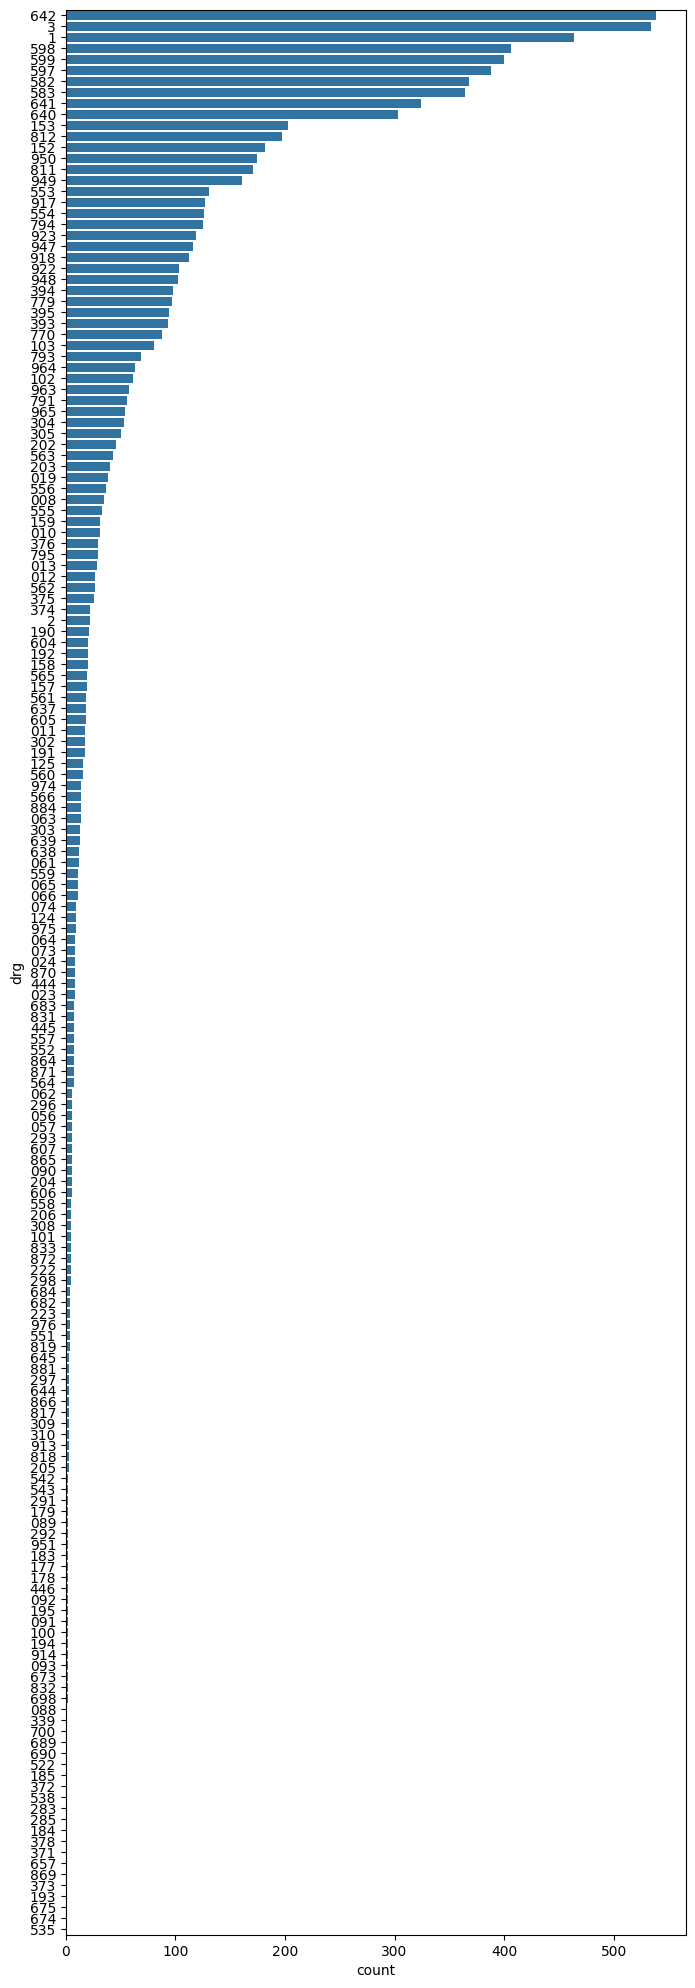

In [173]:
fig, ax = plt.subplots(figsize=(8, 25))
sns.countplot(y='drg', data=non_na_drg, order=non_na_drg['drg'].value_counts().index)

In [176]:
# Percentage breakdown
vals = non_na_drg['drg'].value_counts(normalize=True) * 100
pd.DataFrame({
  'drg_breakdown': vals
}).head(10)

,drg_breakdown
drg,
642,6.309259
3,6.250732
1,5.431347
598,4.752429
599,4.682196
597,4.541730
582,4.307620
583,4.260798
641,3.792579


In [178]:
len(processed_claim.columns)

90

In [2]:
%watermark

Last updated: 2025-09-22T23:59:12.209541+08:00

Python implementation: CPython
Python version       : 3.11.9
IPython version      : 9.5.0

Compiler    : MSC v.1938 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 183 Stepping 1, GenuineIntel
CPU cores   : 20
Architecture: 64bit

